**CAPSTONE MODUL 3 : BIKE SHARING - IVAN SETYA ANANDA**

****
# **Business Understanding**
****

**Context:**
***
Capital Bikeshare is a bike-sharing program in the Washington, D.C. metropolitan area, including parts of Maryland and Virginia.
Bike-sharing systems represent a modern evolution of traditional bike rentals, automating the entire process from membership to rental and return. Users can effortlessly rent a bike from one station and return it to another

Capital Bikeshare offers various pricing plans to categorize to different user needs. They have single trip options, day passes, monthly memberships, and annual memberships. This variety allows them to target occasional riders, tourists, and regular commuters effectively.


**Stakelhoders:**
***
Marketing Team ( Capital Bikeshare company)
 -  **Role:** Regression approach for optimize revenue.
 -  **Involvement:** Setting up new price plans.


**Problem Statement:**
***
- Optimized Pricing. Which key features are significant in predicting total bike demand? Finding the sweet spot in pricing is crucial. We want to increase the optimum revenue by doing dynamic price by the importance key factors.
- Environmental Influence. Which key features are significant in predicting total bike demand in varying conditions? Weather, hour, and temperature all influence how and when people use bike-sharing services. 

**Business Objective:**
***
Marketing Team Capital Bikeshare Company wants to know:
1.	Which Key Features are significant in predicting the total shared bike demand
2.	How we implement the dynamic pricing for our predicted demand


***

In [2]:
# import the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

In [3]:
bike = pd.read_csv('data_bike_sharing.csv')
bike

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857
...,...,...,...,...,...,...,...,...,...,...,...
12160,2012-01-25,0.75,1,0,1,0.2273,0.24,7,14,243,257
12161,2012-07-06,0.62,1,0,3,0.7424,0.78,0,39,63,102
12162,2012-02-20,0.60,2,1,1,0.2121,0.24,5,0,6,6
12163,2012-03-31,0.77,2,0,2,0.4242,0.42,2,14,55,69


***
# **Data Collection and Preprocessing**
***

## **Collect Data**

In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atemp       12165 non-null  float64
 6   temp        12165 non-null  float64
 7   hr          12165 non-null  int64  
 8   casual      12165 non-null  int64  
 9   registered  12165 non-null  int64  
 10  cnt         12165 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


There is data type error for `dteday` column; it should be `DateTime`, because of data datetime type.

There are data types error for `weathersit, holiday, season` columns; it should be `Category`.

## **Clean Data**

In [5]:
missing_columns = (bike.isnull().sum())*100/len(bike)
missing_rows = (bike.isnull().sum(axis=1))*100/len(bike)
display(missing_columns,missing_rows)

dteday        0.0
hum           0.0
weathersit    0.0
holiday       0.0
season        0.0
atemp         0.0
temp          0.0
hr            0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12160    0.0
12161    0.0
12162    0.0
12163    0.0
12164    0.0
Length: 12165, dtype: float64

<Axes: >

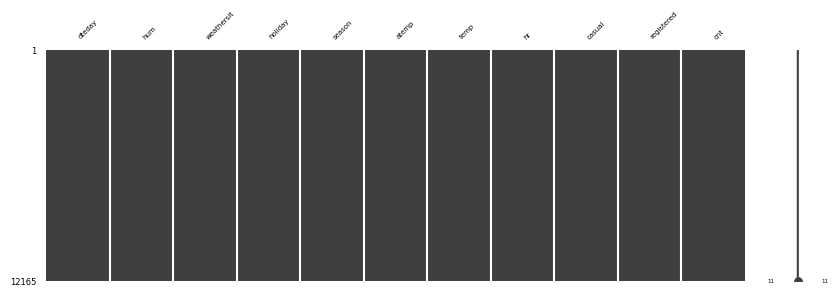

In [6]:
import missingno as msn
msn.matrix(bike,figsize=(10,3),fontsize=5)

In [7]:
bike.duplicated().sum()

0

**Summary**
- There are 12165 rows and 11 columns.
- There are data type errors for ; `dteday,weathersit, holiday, season, hr`.
- There are no missing values in dataset.
- There are no duplicate in dataset.
***

 ## **Feature Engineering**

In [8]:
bike['dteday'] = pd.to_datetime(bike['dteday'])
bike['day'] = bike['dteday'].dt.day_of_week
bike['month'] = bike['dteday'].dt.month

`dteday` column has data type DateTime, this column cannot be used as a model feature. However, in order not to lose important information it will be separated into categorical type such as `day` and `month` because according to the assumption day and month can be influencing variables for the model prediction target.

In [9]:
bike_new=bike[['hum','weathersit','holiday','season','temp','atemp','hr','cnt','day','month']]
bike_new.columns

Index(['hum', 'weathersit', 'holiday', 'season', 'temp', 'atemp', 'hr', 'cnt',
       'day', 'month'],
      dtype='object')

Select all the columns that will be used as model features by creating new variables.

In [10]:

def map_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4
    else:
        return None 

bike_new['quarter'] = bike_new['month'].apply(map_quarter)


Binning the `month` column to create `quarter` column to prevent high cardinality.

In [11]:
bike_new['rush_hour'] = np.where(((bike_new['hr'] >= 7) & (bike_new['hr'] < 9)) | ((bike_new['hr'] >= 17) & (bike_new['hr'] < 19)), 1, 0)

Create new colum `rush_hour` to identifying peak demand periods for bike rentals, allowing for better analysis and decision-making regarding bike availability and distribution. Column set to 1 if the `hour (hr)` is between 7-9 AM or 5-7 PM, otherwise it is set to 0.

In [12]:
bike_new['season'].replace({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}, inplace=True)
bike_new['weathersit'].replace({1: 'Clear', 2: 'Mist', 3: 'Light Rain/Snow', 4: 'Heavy Rain/Snow'}, inplace=True)
bike_new['holiday'].replace({1:'Yes', 0:'No'}, inplace=True)

Change the categorical variabel's values for more readability.

In [13]:
bike_new['season']=bike_new['season'].astype('category')
bike_new['weathersit']=bike_new['weathersit'].astype('category')
bike_new['month']=bike_new['month'].astype('category')
bike_new['day']=bike_new['day'].astype('category')
bike_new['holiday']=bike_new['holiday'].astype('category')
bike_new['quarter']=bike_new['quarter'].astype('category')
bike_new['rush_hour'] = bike_new['rush_hour'].astype('category')

Change the datatype for all categorical into `category` datatype.

In [14]:
bike_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   hum         12165 non-null  float64 
 1   weathersit  12165 non-null  category
 2   holiday     12165 non-null  category
 3   season      12165 non-null  category
 4   temp        12165 non-null  float64 
 5   atemp       12165 non-null  float64 
 6   hr          12165 non-null  int64   
 7   cnt         12165 non-null  int64   
 8   day         12165 non-null  category
 9   month       12165 non-null  category
 10  quarter     12165 non-null  category
 11  rush_hour   12165 non-null  category
dtypes: category(7), float64(3), int64(2)
memory usage: 559.8 KB


**Summary**
- Because of `dteday` cannot be included in model prediction because of neither numerical nor categorical, otherwise `dteday` splitted into 2 new columns` month` and `day`.
- Binning the `month` into `quarter`, because we want to convert month into smaller parts for one hot encoding.
- Refining all of the categorical variables into `category` datatype.
***


 ## **Outlier Handling**

In [15]:
num_columns = bike_new[['hum','temp','atemp','cnt']]

In [16]:
num_columns.describe().loc[['max','50%','min','mean']]

,hum,temp,atemp,cnt
max,1.000000,1.000000,1.000000,970.000000
50%,0.620000,0.500000,0.484800,142.000000
min,0.000000,0.020000,0.000000,1.000000
mean,0.625451,0.498185,0.476996,189.271023


- The range of `humidity` values is from 0 to 1, with an average humidity around 0.625. This indicates a generally high humidity environment on average.
- The median and mean values for both are around the midpoint (0.5), indicating a balanced distribution of `temperatures`.
- The median `count` is 142, and the mean is slightly higher at approximately 189, suggesting a right-skewed distribution with some days having very high rentals.

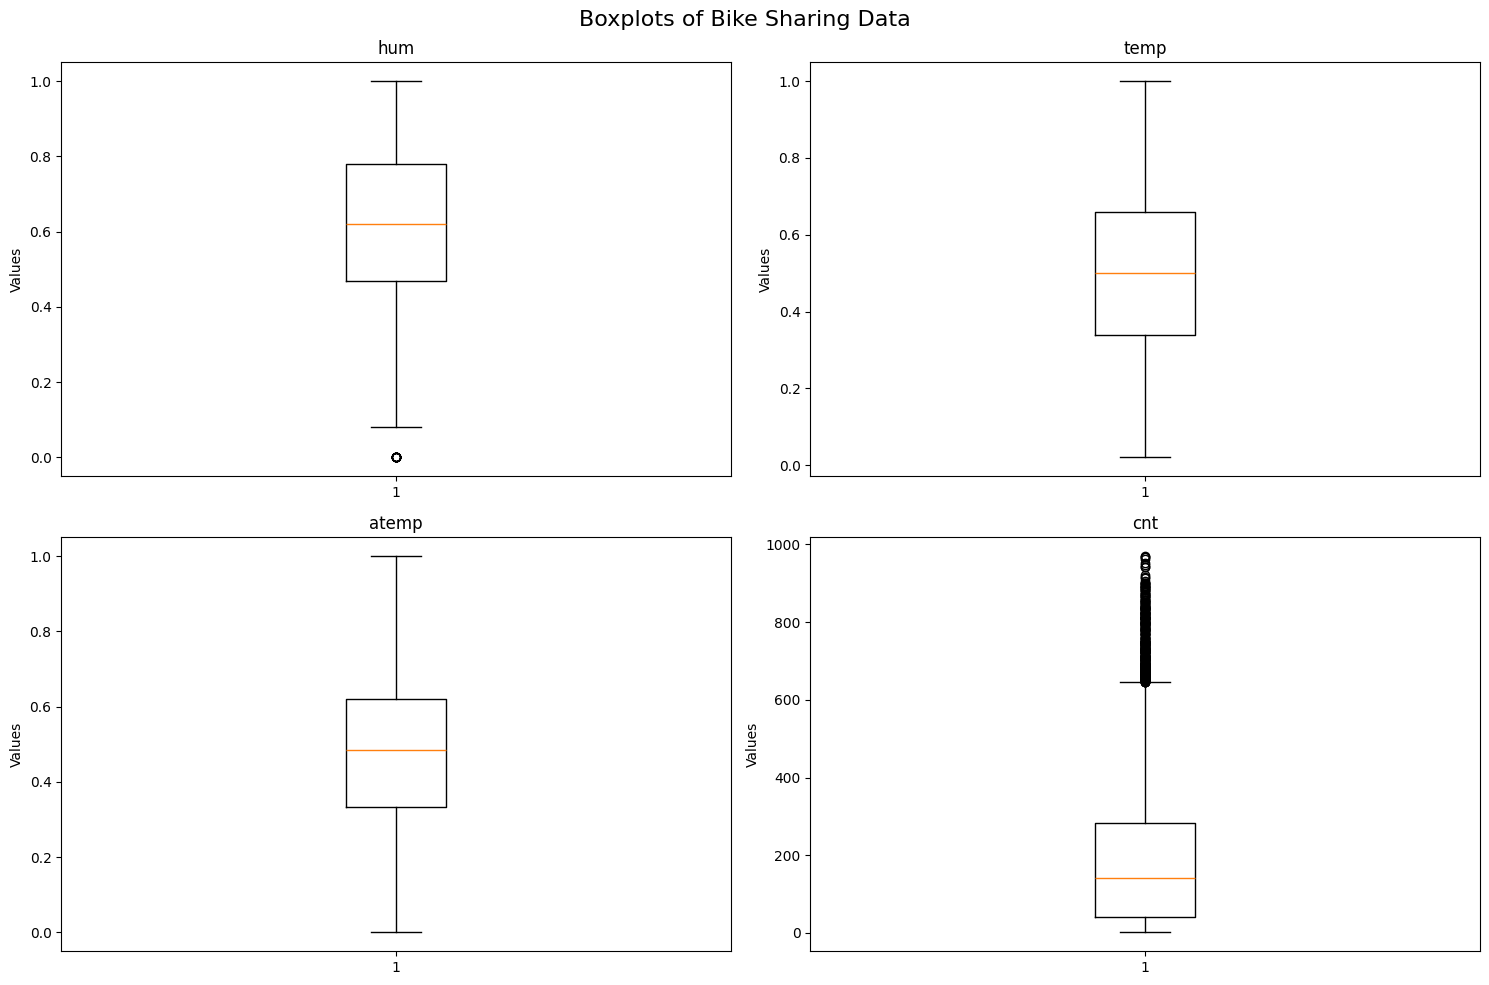

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Boxplots of Bike Sharing Data', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(num_columns):
    axes[i].boxplot(bike[column])
    axes[i].set_title(column)
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

There are outliers in `count` and `hum` columns

In [18]:
# Outliers for casual check
outliers = bike[bike['cnt'] >= 614]

# Count occurrences of each dteday
dteday_counts = outliers['dteday'].value_counts()

# Filter for dteday values that occur more than once
repeated_dtedays = dteday_counts[dteday_counts > 1].index

# Filter outliers for those dteday values
outliers_with_repeated_dtedays = outliers[outliers['dteday'].isin(repeated_dtedays)]
outliers_with_repeated_dtedays.sort_values(by='cnt', ascending=False)

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt,day,month
138,2012-09-11,0.28,1,0,3,0.6364,0.70,17,168,802,970,1,9
8333,2012-10-24,0.47,1,0,4,0.6212,0.66,17,87,876,963,2,10
989,2012-09-26,0.48,1,0,4,0.6667,0.74,17,77,876,953,2,9
9118,2012-10-10,0.43,1,0,4,0.5455,0.58,17,91,857,948,2,10
12027,2012-10-16,0.39,1,0,4,0.5000,0.52,17,104,839,943,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,2012-10-13,0.36,1,0,4,0.4848,0.50,15,251,364,615,5,10
2417,2012-09-15,0.36,2,0,3,0.6212,0.64,18,232,382,614,5,9
5625,2012-03-27,0.16,1,0,2,0.4394,0.44,17,72,542,614,1,3
10098,2012-07-31,0.62,3,0,3,0.6818,0.74,19,90,524,614,1,7


Find all the reasonable evidence for deleting the `count` outlier based on the `dteday` that appears more than 1 on data count outliers, check all the relevant event based on the features `temp`,`hum`, `weathersit`,`holiday`.


| Date | Evidence | Actionable Insight |
|---------|-------------------------|------------------------|
| 2012-09-11 (5 PM)  | -               | cannot find any relevant event on the day              |
| 2012-09-26 (5 PM)   | -               | cannot find any relevant event on the day               |
| 2012-10-10 (5 PM)   | -                | cannot find any relevant event on the day               |
| 2012-10-16 (5 PM)   | -                | cannot find any relevant event on the day               | 
| 2012-10-24 (5 PM)   | Hurricane Sandy on Washington DC 21-31 October 2012               | [ there is an evidence that related to temperature and weather, but on that article the destructive category was on 29 October 2012 ]( https://zoom.earth/storms/sandy-2012/#map=satellite-hd )              |

It is found that in the top 5 total bicycle rentals we do not have enough related evidence to remove outliers to prevent loss of information, so the outlier` count` data will be retained.


In [19]:
# Outliers for humidity check
outliers = bike[bike_new['hum'] <= 0.0500]
outliers

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt,day,month
345,2011-03-10,0.0,3,0,1,0.3939,0.38,7,1,36,37,3,3
871,2011-03-10,0.0,3,0,1,0.4394,0.44,15,3,11,14,3,3
1645,2011-03-10,0.0,3,0,1,0.3182,0.34,0,3,0,3,3,3
3239,2011-03-10,0.0,2,0,1,0.4394,0.44,17,2,109,111,3,3
3717,2011-03-10,0.0,2,0,1,0.3333,0.34,22,4,30,34,3,3
4924,2011-03-10,0.0,3,0,1,0.3333,0.36,6,0,12,12,3,3
7285,2011-03-10,0.0,3,0,1,0.3182,0.34,1,0,2,2,3,3
7760,2011-03-10,0.0,3,0,1,0.4242,0.42,12,4,30,34,3,3
8412,2011-03-10,0.0,3,0,1,0.3939,0.38,8,1,43,44,3,3
8960,2011-03-10,0.0,3,0,1,0.3485,0.34,23,1,26,27,3,3


There are 14 rows that have hum with 0.0 values, It is not possible for outdoor humidity to reach 0%. Humidity is the amount of moisture in the air, and even the driest desert air will have some moisture. For more detailed information can be research to [NOAA SciJinks](https://scijinks.gov/what-is-humidity/), therefore deleting hum outliers will be proceed.

In [20]:
results = {}

for col in num_columns:
    q3 = bike_new[col].describe().loc['75%']
    q1 = bike_new[col].describe().loc['25%']

    iqr = q3 - q1

    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    upper_outliers = (bike_new[col] > upper).sum()
    lower_outliers = (bike_new[col] < lower).sum()
    total_outliers = upper_outliers + lower_outliers

    total_count = len(bike_new[col])
    upper_percent = (upper_outliers / total_count) * 100
    lower_percent = (lower_outliers / total_count) * 100
    total_percent = (total_outliers / total_count) * 100

    results[col] = {
        'Upper fence': upper,
        'Lower fence': lower,
        'Upper outliers': upper_outliers,
        'Upper outliers %': upper_percent,
        'Lower outliers': lower_outliers,
        'Lower outliers %': lower_percent,
        'Total outliers': total_outliers,
        'Total outliers %': total_percent
    }

show_outliers = pd.DataFrame(results).T.sort_values(by='Total outliers', ascending=False)
show_outliers

,Upper fence,Lower fence,Upper outliers,Upper outliers %,Lower outliers,Lower outliers %,Total outliers,Total outliers %
cnt,645.00000,-323.00000,338.0,2.778463,0.0,0.000000,338.0,2.778463
hum,1.24500,0.00500,0.0,0.000000,14.0,0.115084,14.0,0.115084
temp,1.14000,-0.14000,0.0,0.000000,0.0,0.000000,0.0,0.000000
atemp,1.05305,-0.09855,0.0,0.000000,0.0,0.000000,0.0,0.000000


Using IQR method to explain about the upper fence and lower fence
- There total 2.778463% `count` outliers
- There total 0.115084% `humidity` outliers

In [21]:
bike_new = bike_new[bike_new['hum'] >= 0.00500]
print(bike_new.shape)

(12151, 12)


After outliers handling total rows decreased from 12165 to 12151.

**Summary**
- There are outliers for `count` and `humidity` columns.
- `Count` column outliers **DOESN'T** have enough evidence to be dropped,therefore the information will be keeped.
- `Humidty` column outliers have enough evidence and it has total 0.115084% so it will not affected the dataset, therefore the information will be dropped.
- After outliers handling total rows decreased from **12165** to **12151**.
***

## **Preprocessing**

In [22]:
cat_columns = bike_new[['weathersit','season','holiday','day','quarter','rush_hour']]

In [23]:
pd.set_option('display.max_colwidth', None)

pd.DataFrame({
    'feature':cat_columns.columns.values,
    'negative':[True if cat_columns[i].dtype == int and (cat_columns[i] < 0).any() else False for i in cat_columns.columns],
    'n_unique':cat_columns.nunique().values,
    'sample_unique':[cat_columns[i].unique() for i in cat_columns.columns]
})

,feature,negative,n_unique,sample_unique
0,weathersit,False,4,"['Clear', 'Mist', 'Light Rain/Snow', 'Heavy Rain/Snow'] Categories (4, object): ['Clear', 'Heavy Rain/Snow', 'Light Rain/Snow', 'Mist']"
1,season,False,4,"['Fall', 'Spring', 'Summer', 'Winter'] Categories (4, object): ['Fall', 'Spring', 'Summer', 'Winter']"
2,holiday,False,2,"['No', 'Yes'] Categories (2, object): ['No', 'Yes']"
3,day,False,7,"[4, 6, 2, 5, 1, 0, 3] Categories (7, int32): [0, 1, 2, 3, 4, 5, 6]"
4,quarter,False,4,"[4, 2, 1, 3] Categories (4, int64): [1, 2, 3, 4]"
5,rush_hour,False,2,"[0, 1] Categories (2, int32): [0, 1]"


There are 6 categorical features for data aid in regression

<Axes: title={'center': 'After Min-Max Scaling'}, xlabel='temp', ylabel='Density'>

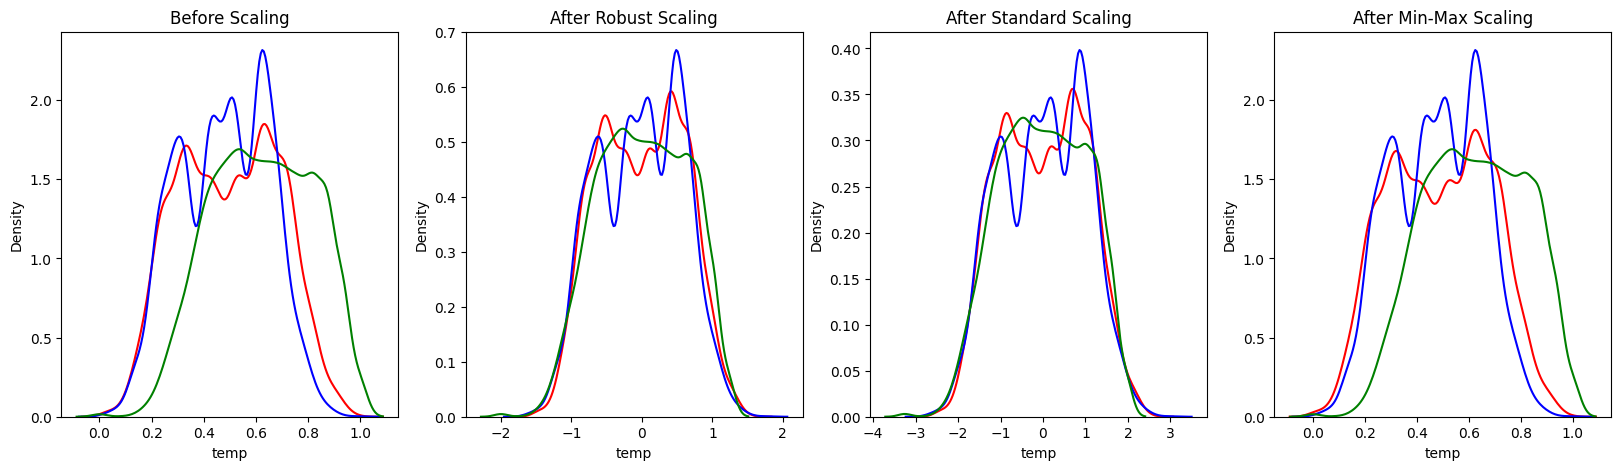

In [24]:
test = num_columns
scalerR = RobustScaler()
robust_df = scalerR.fit_transform(test)
robust_df = pd.DataFrame(robust_df, columns=test.columns)

scalerS = StandardScaler()
standard_df = scalerS.fit_transform(test)
standard_df = pd.DataFrame(standard_df, columns=test.columns)

scalerM = MinMaxScaler()
minmax_df = scalerM.fit_transform(test)
minmax_df = pd.DataFrame(minmax_df, columns=test.columns)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(test['temp'], ax = ax1, color ='r')
sns.kdeplot(test['atemp'], ax = ax1, color ='b')
sns.kdeplot(test['hum'], ax = ax1, color ='g')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['temp'], ax = ax2, color ='red')
sns.kdeplot(robust_df['atemp'], ax = ax2, color ='blue')
sns.kdeplot(robust_df['hum'], ax = ax2, color ='green')

ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['temp'], ax = ax3, color ='r')
sns.kdeplot(standard_df['atemp'], ax = ax3, color ='b')
sns.kdeplot(standard_df['hum'], ax = ax3, color ='g')

ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['temp'], ax = ax4, color ='r')
sns.kdeplot(minmax_df['atemp'], ax = ax4, color ='b')
sns.kdeplot(minmax_df['hum'], ax = ax4, color ='g')

The image provided shows the effect of different scaling techniques
- Before Scaling: The raw data distributions vary significantly in their range and scale.
- After Robust Scaling: The data is centered around the median with reduced outlier influence, aligning the distributions better.
- After Standard Scaling: The data is centered around zero with a standard deviation of one, normalizing the distributions.
- After Min-Max Scaling: The data is scaled within the 0 to 1 range, preserving the shape of the original distributions but aligning them within a specific range

`Robust Scaling` is useful for datasets with outliers.
`Standard Scaling` is useful for algorithms that assume normally distributed data.
`Min-Max Scaling` is useful when the data needs to be within a specific range, especially for algorithms that are sensitive to the scale of the data.

In [25]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False), ['weathersit', 'holiday', 'season','quarter','day','rush_hour']),
], remainder='passthrough')

`ColumnTransformer` to apply different preprocessing steps to different subsets because later it will be run on pipeline.

`OneHotEncoder` all the categorical variabels into numerical.

`sparse_output` to ensures that the output is a dense array instead of a sparse matrix, making it easier to integrate with other parts of the pipeline that expect dense arrays.


**Summary**
- There are 6 categorical features for independent variables
- After benchmarking what the best standarization method for the model there were intepret Robust and Standar are good to implement because there have more dense plot than minmax. Therefore in linear model regression we will use `RobustScaler()` for outlier in the dataset
- Encapsulated all the categorical and encoded into numerical with `OneHotEncoder()`, set (sparse_output= False) to prevent dimensionality mismatch when intepret with tree-based non linear model
***

 ***
 # **EDA**
 ***

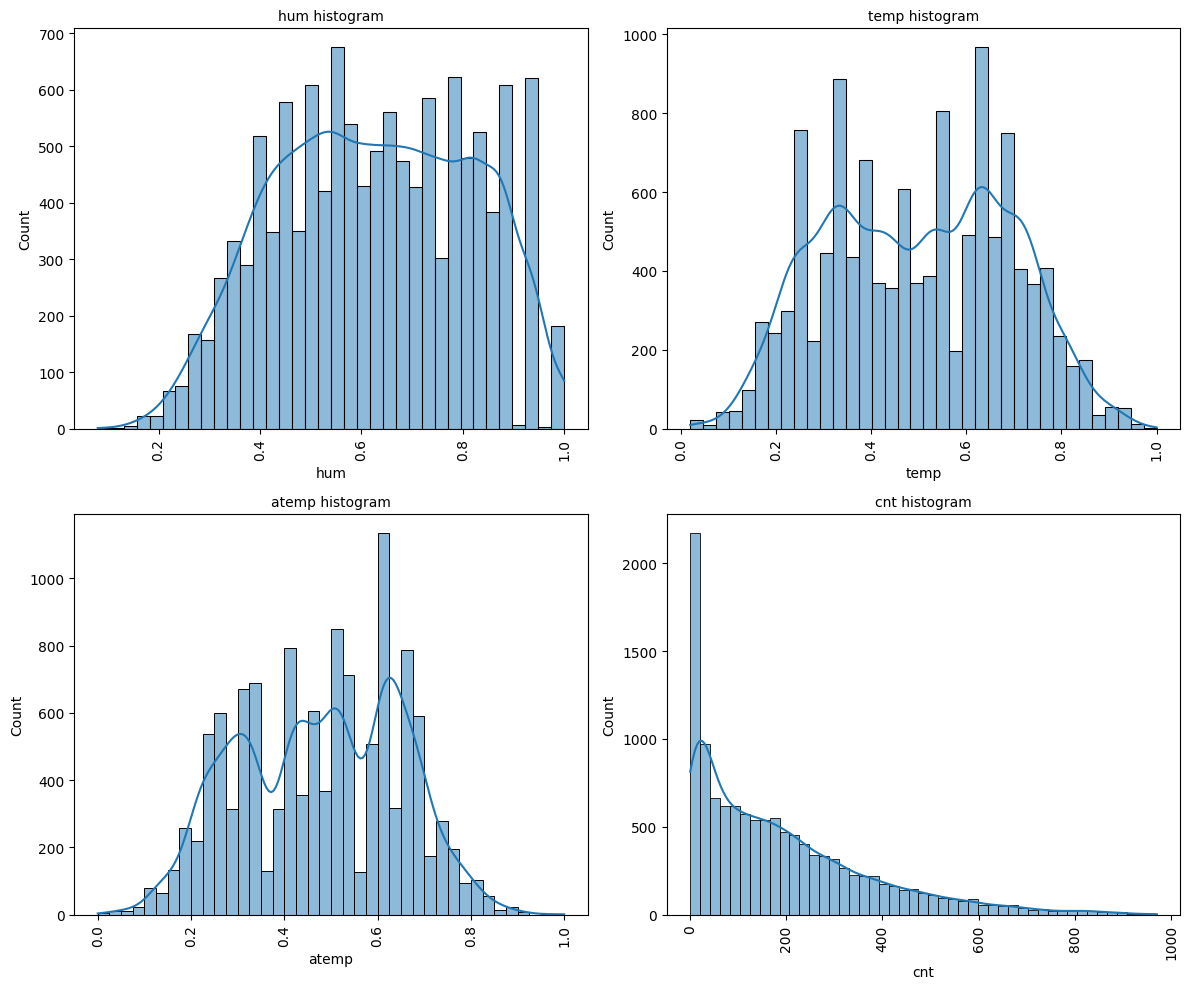

In [26]:
num_feats = bike_new[['hum','temp','atemp','cnt']]
plt.figure(figsize=(12, 10))

for i, var in enumerate(num_feats.columns):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{var} histogram", fontsize=10)
    sns.histplot(data=bike_new, x=var, kde=True)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

 **1. Humidity (`hum`)**
- **Distribution**: Slightly right-skewed.
- **Range**: 0 to 1.
- **Observations**: 
  - Peak around 0.6 to 0.8.
  - Few instances of very low or very high humidity.

**2. Temperature (`temp`)**
- **Distribution**: Approximately normal distribution with slight right skew.
- **Range**: 0 to 1.
- **Observations**:
  - Peaks at around 0.6.
  - Temperature values are well-distributed across the range.

**3. Adjusted Temperature (`atemp`)**
- **Distribution**: Bimodal distribution.
- **Range**: 0 to 1.
- **Observations**:
  - Two distinct peaks around 0.4 and 0.6.
  - Indicates two common temperature ranges.

**4. Bike Rental Counts (`cnt`)**
- **Distribution**: Right-skewed.
- **Range**: 0 to 1000.
- **Observations**:
  - High frequency of low rental counts.
  - Decreasing frequency with higher rental counts.


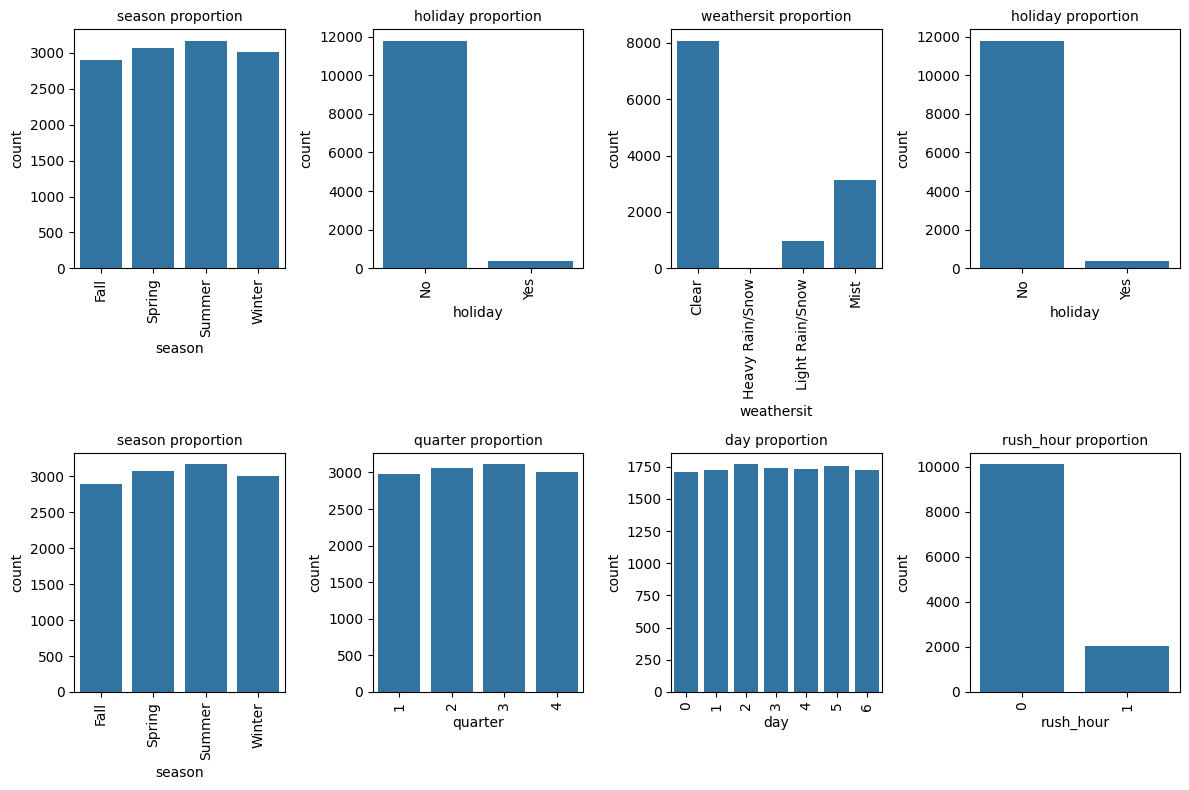

In [27]:
cat_feats = bike_new[['season','holiday','weathersit', 'holiday', 'season','quarter','day','rush_hour']]
plt.figure(figsize=(12, 8))
for i, var in enumerate(cat_feats.columns):
    plt.subplot(2, 4, i+1)
    plt.title(f"{var} proportion", fontsize=10)
    sns.countplot(data=bike_new, x=var)
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()
plt.show()

**1. Season Proportion**
- **Fall**: Slightly less than other seasons.
- **Spring, Summer, Winter**: Approximately equal distribution, each around 3000 counts.
- **Observations**: The data is well-distributed across seasons with minor variations.

**2. Holiday Proportion**
- **No Holiday**: Dominates with nearly 12,000 counts.
- **Holiday**: Very few instances.
- **Observations**: Most of the data points are from non-holiday periods.

**3. Weathersit Proportion**
- **Clear**: The most common weather condition, around 8000 counts.
- **Mist**: The second most common, significantly less than clear weather.
- **Light Rain/Snow, Heavy Rain/Snow**: Least common weather conditions.
- **Observations**: Clear weather is predominant, with mist being a notable secondary condition.

**4. Quarter Proportion**
- **All Quarters (1, 2, 3, 4)**: Approximately equal distribution, each around 3000 counts.
- **Observations**: Data is evenly distributed across the four quarters.

**5. Day Proportion**
- **Days 0 to 6**: Nearly equal distribution, each around 1500 to 1750 counts.
- **Observations**: Data is well-distributed across all days of the week.

**6. Rush Hour Proportion**
- **Non-Rush Hour (0)**: Total 24 hours except the range for rush hour nearly 10,000 counts.
- **Rush Hour (1)**: Significantly fewer instances.
- **Observations**: The majority of data points are from non-rush hours, indicating lower activity during rush hours.




**Summary**
- **Numerical Features Distribution**
    - The distributions of humidity and temperature are relatively balanced, with minor skewness.
    - Adjusted temperature shows a clear bimodal pattern, indicating varying temperature experiences.
    - Bike rental counts are predominantly low, highlighting the need to understand factors driving higher rental demand.

- **Categorical Features Distribution**
    - The categorical data is generally well-distributed across seasons, quarters, and days, providing a balanced view for analysis.
    - Skewness in holiday and rush hour proportions indicates a focus on non-holiday and non-rush hour periods, but it can matter with data distibution also.
    - Dominance of clear weather suggests a potential influence on rental pattern.


***

 ***
 # **Feature Selection**
 ***

## **Numerical Continuous Features Selection**

In [28]:
corr_temp_cnt = bike_new['temp'].corr(bike_new['cnt'])
corr_atemp_cnt = bike_new['atemp'].corr(bike_new['cnt'])
corr_hum_cnt = bike_new['hum'].corr(bike_new['cnt'])

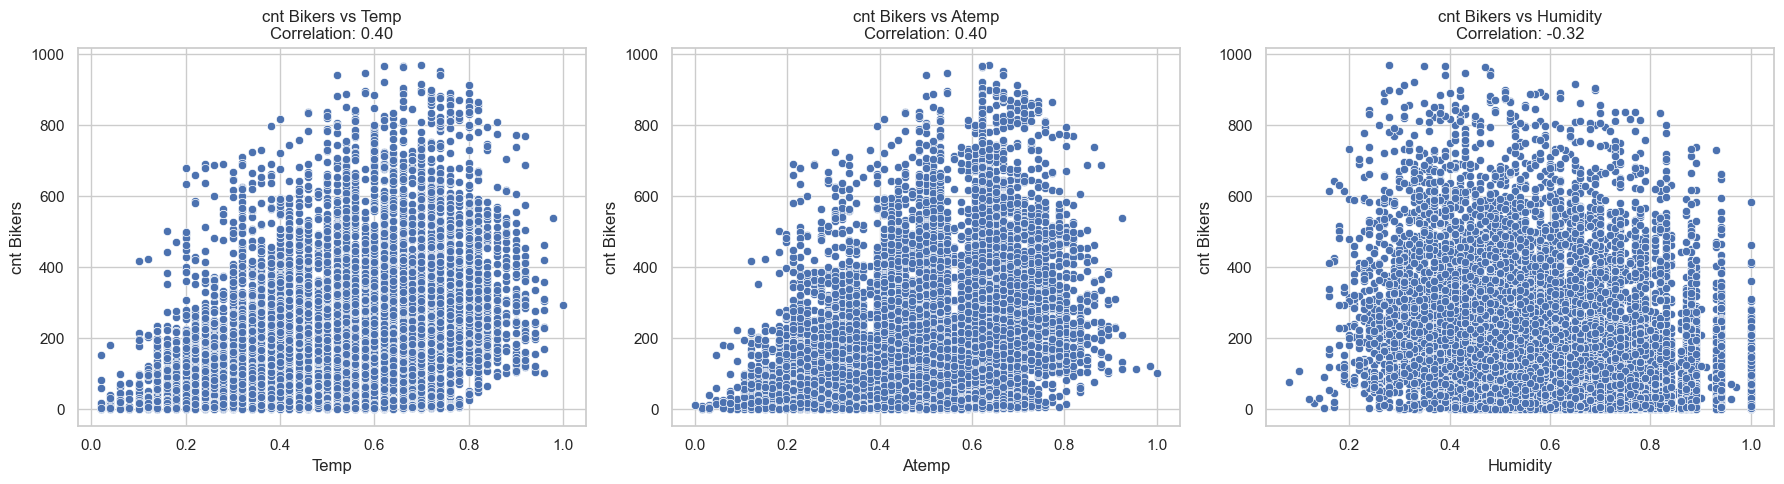

In [29]:

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(ax=axes[0], x='temp', y='cnt', data=bike_new)
axes[0].set_title(f'cnt Bikers vs Temp\nCorrelation: {corr_temp_cnt:.2f}')
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('cnt Bikers')

sns.scatterplot(ax=axes[1], x='atemp', y='cnt', data=bike_new)
axes[1].set_title(f'cnt Bikers vs Atemp\nCorrelation: {corr_atemp_cnt:.2f}')
axes[1].set_xlabel('Atemp')
axes[1].set_ylabel('cnt Bikers')

sns.scatterplot(ax=axes[2], x='hum', y='cnt', data=bike_new)
axes[2].set_title(f'cnt Bikers vs Humidity\nCorrelation: {corr_hum_cnt:.2f}')
axes[2].set_xlabel('Humidity')
axes[2].set_ylabel('cnt Bikers')

plt.tight_layout()
plt.show()

The analysis highlights the correlations between the independent variables and the dependent variable, bike rental counts:
- **Temperature and Adjusted Temperature**: Both show a strong positive correlation with bike rentals, peaking at moderate levels (around 0.4). This suggests that comfortable temperature conditions are a major factor driving bike rental demand.
- **Humidity**: Shows a weaker correlation with bike rentals. High humidity may deter rentals, but its overall impact is less significant compared to temperature.

In [30]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['temp']]))
result = sm_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     2325.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:18:07   Log-Likelihood:                -79360.
No. Observations:               12151   AIC:                         1.587e+05
Df Residuals:                   12149   BIC:                         1.587e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4649      4.179      0.351      0.7

In [31]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['atemp']]))
result = sm_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     2293.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:18:07   Log-Likelihood:                -79374.
No. Observations:               12151   AIC:                         1.588e+05
Df Residuals:                   12149   BIC:                         1.588e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9600      4.449     -2.464      0.0

In [32]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['hum']]))
result = sm_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1432.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          2.51e-296
Time:                        23:18:08   Log-Likelihood:                -79747.
No. Observations:               12151   AIC:                         1.595e+05
Df Residuals:                   12149   BIC:                         1.595e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        382.3621      5.330     71.742      0.0

In [33]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['temp','atemp']]))
result = sm_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     1165.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:18:08   Log-Likelihood:                -79358.
No. Observations:               12151   AIC:                         1.587e+05
Df Residuals:                   12148   BIC:                         1.587e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8527      4.673     -0.611      0.5

In [34]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['temp','hum']]))
result = sm_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     2011.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:18:08   Log-Likelihood:                -78686.
No. Observations:               12151   AIC:                         1.574e+05
Df Residuals:                   12148   BIC:                         1.574e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        188.2310      6.334     29.719      0.0

In [35]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['atemp','hum']]))
result = sm_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     2035.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:18:08   Log-Likelihood:                -78669.
No. Observations:               12151   AIC:                         1.573e+05
Df Residuals:                   12148   BIC:                         1.574e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.9399      6.442     27.624      0.0

In [36]:
sm_lm = sm.OLS(bike_new['cnt'], sm.add_constant(bike_new[['temp','atemp','hum']]))
result = sm_lm.fit()

In [37]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1358.
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:18:08   Log-Likelihood:                -78668.
No. Observations:               12151   AIC:                         1.573e+05
Df Residuals:                   12147   BIC:                         1.574e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        179.1933      6.493     27.600      0.0

## Multicolinnearity

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

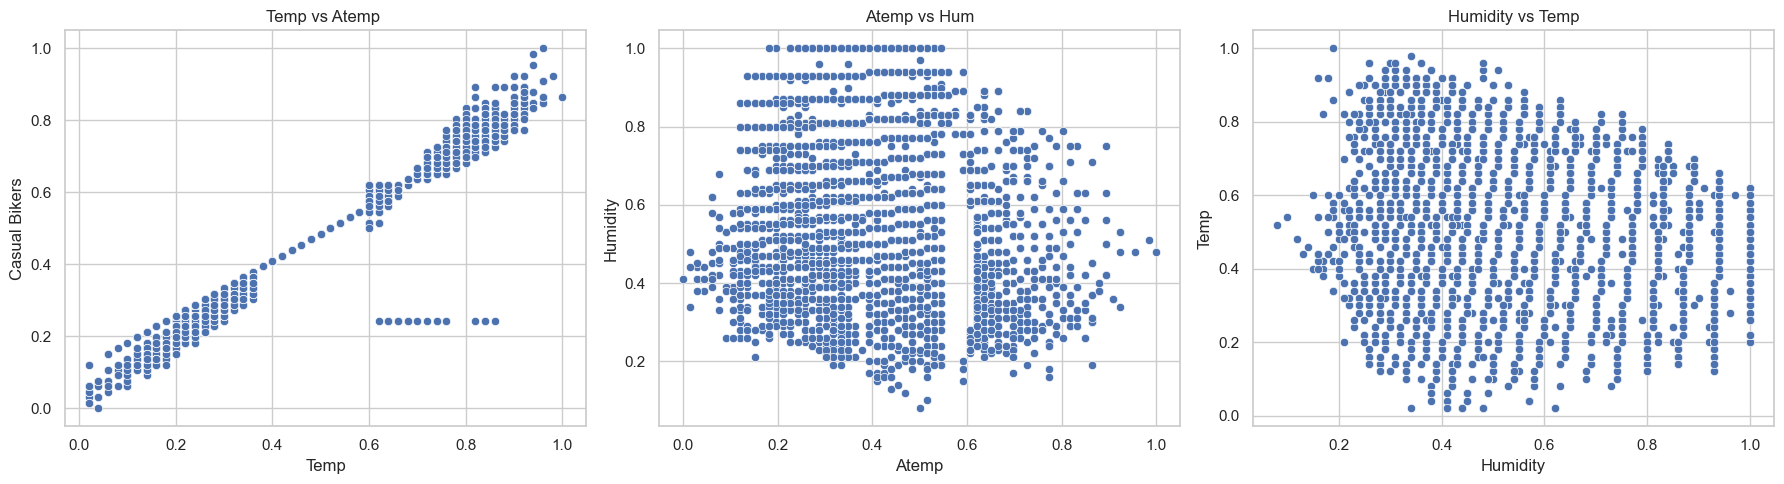

In [39]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(ax=axes[0], x='temp', y='atemp', data=bike_new)
axes[0].set_title('Temp vs Atemp ')
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Casual Bikers')

sns.scatterplot(ax=axes[1], x='atemp', y='hum', data=bike_new)
axes[1].set_title('Atemp vs Hum')
axes[1].set_xlabel('Atemp')
axes[1].set_ylabel('Humidity')

sns.scatterplot(ax=axes[2], x='hum', y='temp', data=bike_new)
axes[2].set_title('Humidity vs Temp')
axes[2].set_xlabel('Humidity')
axes[2].set_ylabel('Temp')

plt.tight_layout()
plt.show()

- **High Multicollinearity**: Between `temp` and `atemp`. Due to their strong relationship, including both in a regression model may cause multicollinearity issues.
- **Low Multicollinearity**: Between `atemp` and `hum`;`hum` and `temp`. The weak relationships between these pairs of variables suggest they don't show significant multicollinearity.

In [40]:
calc_vif(bike_new[['temp','atemp']])

,variables,VIF
0,temp,276.91101
1,atemp,276.91101


In [41]:
calc_vif(bike_new[['temp','hum']])

,variables,VIF
0,temp,4.600812
1,hum,4.600812


In [42]:
calc_vif(bike_new[['atemp','hum']])

,variables,VIF
0,atemp,5.002963
1,hum,5.002963


In [43]:
calc_vif(bike_new[['temp','atemp','hum']])

,variables,VIF
0,temp,305.381693
1,atemp,332.074719
2,hum,5.517344


**Summary**
<center>

| F | p-value | R-squared | Adj. R-squared | X1 | X2 | X3 | VIF |
|---------|-------------------------|------------------------|--------------|--------------|--------------|--------------|--------------|
| 4320    | 0.00               | 0.277              | 0.276    | X    |     |     | 1.00    |
| 4127    | 0.00               | 0.267               | 0.267    |     | X    |     |1.00   |
| 0.267  | 0.00                | 0.128               | 0.128    |     |     | X     | 1.00    |
| 2162    | 0.00                | 0.277               | 0.277    | X    | X    |     | 270.27   |
| 3691    | 0.00                | 0.395               | 0.395   | X    |     | X    | 4.77    |
| 3644    | 0.00                | 0.392               | 0.392  |     | X    | X    | 5.19    |
| 2465    | 0.00                | 0.396               | 0.395 |  X   |  X   |  X   | below   |
|     |     |     |     | 296.13    | 322.4    | 5.69    |     |
<center>

From the results we can see that the highest results and no outliers are in X1 and X3 that are `temp` and `hum` so we use the numerical features.

***

***
# **Model Training**
***

## **Data Splitting**

In [44]:
X = bike_new.drop(columns=['cnt','atemp','month'])
y = bike_new['cnt']

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

## **Benchmark Model**

### **Linear Model**

In [46]:
lr = LinearRegression()

In [47]:
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)

In [48]:
model = log_lr

score_r2 = []
mean_r2 = []
std_r2 = []

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = Pipeline([
('preprocessing', transformer),
('scaler', RobustScaler()),
('model', model)
])

# r2
model_cv_r2 = cross_val_score(
estimator,
X_train,
y_train,
cv=crossval,
scoring='r2',
error_score='raise'
)

score_r2.append(np.abs(model_cv_r2))
mean_r2.append(np.abs(model_cv_r2).mean())
std_r2.append(np.abs(model_cv_r2).std())

benchmark_linear = pd.DataFrame({
    'Train R2': mean_r2,
    'Std R2': std_r2,})
benchmark_linear

,Train R2,Std R2
0,0.077345,0.070626


Text(0.5, 0, 'Residuals')

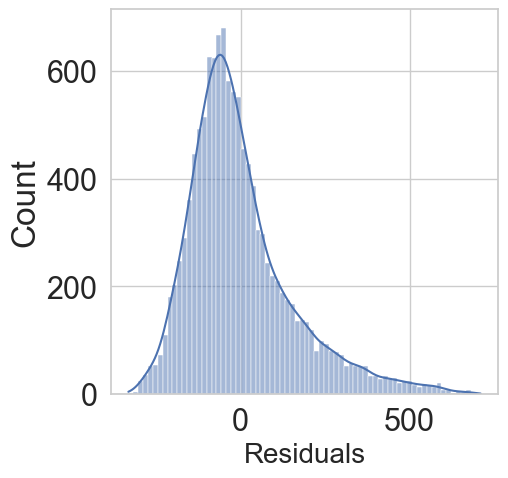

In [49]:
plt.figure(figsize=(5,5))
sns.set_context('notebook',font_scale=2)
sns.histplot(result.resid,kde=True)
plt.xlabel('Residuals', fontsize = 20)

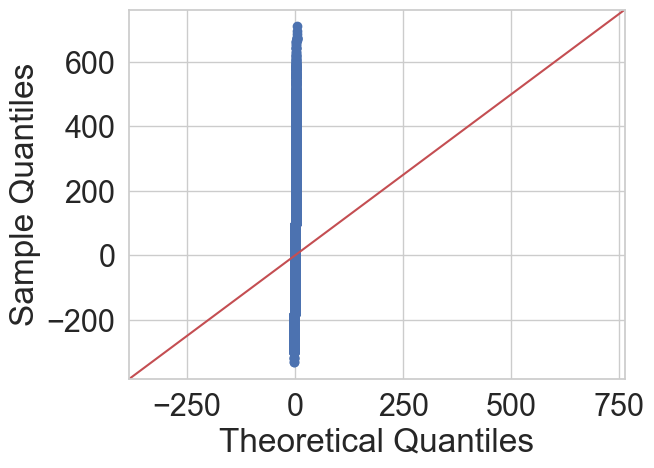

In [50]:
sm.qqplot(result.resid, line = '45')
plt.show()

Text(0, 0.5, 'Residuals')

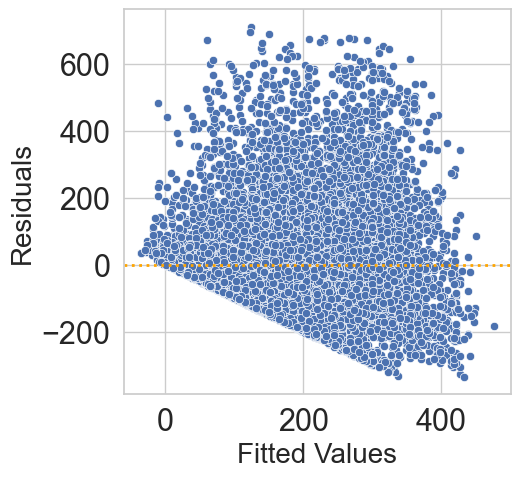

In [51]:
plt.figure(figsize=(5,5))
sns.set_context('notebook',font_scale=2)
ax = sns.scatterplot(x=result.fittedvalues,y=result.resid)
ax.axhline(y=0, linewidth=2, color='orange', ls=':')
plt.xlabel('Fitted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

**Summary**

Assumption Assesment:
1. If we refer to the histogram, the residual NOT normally distributed
1. Model residuals gather around zero
1. No certain pattern in the residual plot
1. Heteroscedasticity Occur

Hence we cannot continue with linear model
***


### **Non-Linear Model**

In [52]:
rf =  RandomForestRegressor(n_estimators=150, random_state=42)
gbc = GradientBoostingRegressor(n_estimators=150, random_state=42)
ada = AdaBoostRegressor(n_estimators=150, random_state=42)
xgb = XGBRegressor(n_estimators=150, random_state=42)

In [53]:
log_gbc = TransformedTargetRegressor(gbc, func=np.log, inverse_func=np.exp)
log_ada = TransformedTargetRegressor(ada, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

- Logarithmic transformation using np.log to stabilize variance and make the data more normally distributed. 
- Followed by an exponential transformation using np.exp to revert the log transformation during the prediction phase. 
- We do transform because we seek data for the target count highly right skew so we want to bruteforce it to almost normal distribution using trans log.


### **Cross Validation**

In [54]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

models = [log_ada, log_gbc, log_rf, log_xgb]

score_rmse = []
mean_rmse = []
std_rmse = []

score_mae = []
mean_mae = []
std_mae = []

score_mape = []
mean_mape = []
std_mape = []

for i in models:
   
    crossval = KFold(n_splits=5, shuffle=True, random_state=42)

    estimator = Pipeline([
        ('preprocessing', transformer),
        # ('scaler', robust),# we dont use normalization because tree-based already robust
        ('model', i)
    ])

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
    )

    score_rmse.append(np.abs(model_cv_rmse))
    mean_rmse.append(np.abs(model_cv_rmse).mean())
    std_rmse.append(np.abs(model_cv_rmse).std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_mean_absolute_error',
        error_score='raise'
    )

    score_mae.append(np.abs(model_cv_mae))
    mean_mae.append(np.abs(model_cv_mae).mean())
    std_mae.append(np.abs(model_cv_mae).std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=crossval,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
    )

    score_mape.append(np.abs(model_cv_mape))
    mean_mape.append(np.abs(model_cv_mape).mean())
    std_mape.append(np.abs(model_cv_mape).std())


In [55]:
estimator

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['weathersit', 'holiday',
                                                   'season', 'quarter', 'day',
                                                   'rush_hour'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   col...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=150,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)))])

In [56]:
benchmark_train = pd.DataFrame({
    'Model': ['AdaBoost Regressor','GradientBoost Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'Train RMSE': mean_rmse,
    'Std RMSE': std_rmse,
    'Train MAE': mean_mae,
    'Std MAE': std_mae,
    'Train MAPE': mean_mape,
    'Std MAPE': std_mape
}).sort_values('Train RMSE', ascending=True)
benchmark_train

,Model,Train RMSE,Std RMSE,Train MAE,Std MAE,Train MAPE,Std MAPE
3,XGBoost Regressor,68.732113,1.460012,43.995340,0.827120,0.342027,0.010259
2,RandomForest Regressor,74.145714,1.814158,47.577147,0.832589,0.373379,0.014831
1,GradientBoost Regressor,87.820161,2.912927,55.633877,1.775177,0.434951,0.018788
0,AdaBoost Regressor,143.953215,5.118318,87.673401,2.837665,0.587084,0.040991


### **Testing Model**

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

models = [log_ada, log_gbc, log_rf, log_xgb]

test_score_rmse = []
test_score_mae = []
test_score_mape = []


for i in models:
    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

   
    estimator.fit(X_train, y_train)

  
    y_pred = estimator.predict(X_test)

   
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_score_rmse.append(rmse)

    mae = mean_absolute_error(y_test, y_pred)
    test_score_mae.append(mae)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    test_score_mape.append(mape)


In [58]:
results = {
    'Model': ['AdaBoost Regressor','GradientBoost Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'Test RMSE': test_score_rmse,
    'Test MAE': test_score_mae,
    'Test MAPE': test_score_mape
}

results_test = pd.DataFrame(results)
results_test.sort_values('Test RMSE', ascending=True)


,Model,Test RMSE,Test MAE,Test MAPE
3,XGBoost Regressor,62.603738,40.631897,0.334214
2,RandomForest Regressor,67.881917,43.774196,0.379223
1,GradientBoost Regressor,83.793574,52.758142,0.448139
0,AdaBoost Regressor,133.541037,79.560287,0.572113


In [59]:
benchmark_model = results_test.set_index('Model').join(benchmark_train.set_index('Model'))
benchmark_model.drop(['Train RMSE','Std RMSE','Train MAE','Std MAE','Std MAPE','Test RMSE','Test MAE'],axis=1,inplace=True)
benchmark_model['diff'] = benchmark_model['Train MAPE'] - benchmark_model['Test MAPE']
benchmark_model['diff'] = benchmark_model['diff'].agg('abs')
benchmark_model.sort_values(by='Test MAPE',ascending=True)

,Test MAPE,Train MAPE,diff
Model,,,
XGBoost Regressor,0.334214,0.342027,0.007813
RandomForest Regressor,0.379223,0.373379,0.005844
GradientBoost Regressor,0.448139,0.434951,0.013188
AdaBoost Regressor,0.572113,0.587084,0.014971


In [60]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from xgboost import XGBRegressor


xgb = XGBRegressor(random_state=42)

pipe_model = Pipeline([
    ('preprocess', transformer),
    ('model', TransformedTargetRegressor(regressor=xgb, func=np.log, inverse_func=np.exp))
])

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

hyperparam_space_xgb = {
    'model__regressor__n_estimators': [100,150, 200,250, 300],
    'model__regressor__max_depth': [3, 5, 7],
    'model__regressor__learning_rate': [0.01, 0.05, 0.1],
    'model__regressor__subsample': [0.8, 0.9, 1.0],
    'model__regressor__colsample_bytree': [0.8, 0.9, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space_xgb,
    cv=crossval,
    scoring='neg_mean_absolute_error',
    n_iter=100,
    n_jobs=-1,
    random_state=42
)


random_search_xgb.fit(X_train, y_train)

print("Best parameters found: ", random_search_xgb.best_params_)
print("Best MAPE: ", -random_search_xgb.best_score_)


Best parameters found:  {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 300, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.1, 'model__regressor__colsample_bytree': 1.0}
Best MAPE:  42.501475977308964


### **Model After Tuning**

In [61]:
final_model_xgb = XGBRegressor(subsample= 0.9, n_estimators= 250, max_depth= 7, learning_rate= 0.1, colsample_bytree= 0.9)

xgb_pipeline = Pipeline([
    ('preprocess', transformer),
    ('modeling', TransformedTargetRegressor(regressor=final_model_xgb, func=np.log, inverse_func=np.exp))
])

xgb_pipeline.fit(X_train, y_train)


y_pred_xgb_tuning = xgb_pipeline.predict(X_test)

rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'MAPE': mape_xgb_tuning,'RMSE':rmse_xgb_tuning,'MAE':mae_xgb_tuning}, index=['XGBRegressor'])
score_after_tuning

,MAPE,RMSE,MAE
XGBRegressor,0.338329,61.647824,39.835385


In [63]:
features = list(transformer.get_feature_names_out())

list_features = []

for feature in features:
    list_features.append('_'.join(feature.split('_')[2:]))

list_features

['weathersit_Clear',
 'weathersit_Heavy Rain/Snow',
 'weathersit_Light Rain/Snow',
 'weathersit_Mist',
 'holiday_No',
 'holiday_Yes',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'quarter_1',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'rush_hour_0',
 'rush_hour_1',
 'hum',
 'temp',
 'hr']

***
# **Conclusion**
***

### **Explainables AI**

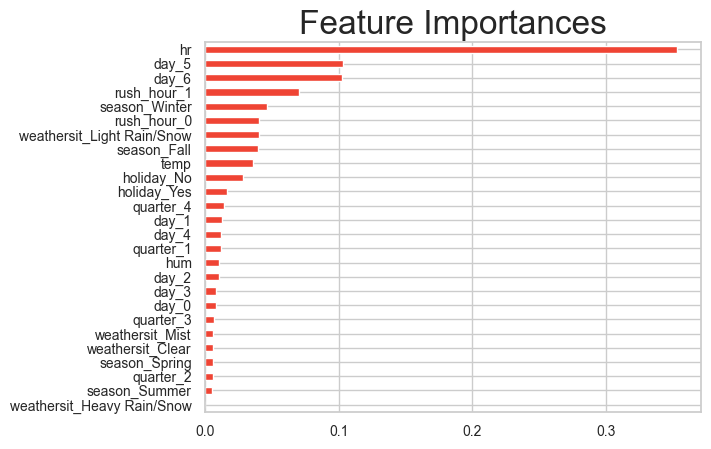

In [64]:
feature_imp = pd.Series(xgb_pipeline['modeling'].regressor_.feature_importances_, list_features).sort_values(ascending = True)
feature_imp.plot(kind='barh', title='Feature Importances', fontsize=10, color='#ef4434');

Feature importance
- `hour` of the day. This makes sense because bike usage varies significantly depending on the time of day, with peak hours seeing the highest demand.
- `day` of the week is also important. Certain days, like weekends or weekdays, show different usage patterns.
- `temperatures` influence bike usage. Weather conditions, such as hot or cold temperatures, can impact how likely people are to use bikes.
- `rush hour` periods are crucial as well. Identifying whether it's a rush hour or not can significantly affect the number of bikes needed.

In [65]:
df_result = pd.DataFrame({
    'Actual Demand' : y_test,
    'Model Prediction' : [round(a) for a in y_pred_xgb_tuning]
})

df_result.reset_index()

,index,Actual Demand,Model Prediction
0,1616,502,487
1,11214,13,20
2,397,134,137
3,8420,192,214
4,9617,116,97
...,...,...,...
2426,9200,184,244
2427,10287,68,63
2428,11195,350,340
2429,3672,257,228


In [66]:
import pandas as pd

df_result = pd.DataFrame({
    'Actual Demand': y_test,
    'Model Prediction': [round(a) for a in y_pred_xgb_tuning]
})

df_result = df_result.reset_index()

print("Row with index 2957:")
print(df_result.loc[df_result['index'] == 2957])

print("\nRow with index 3689:")
print(df_result.loc[df_result['index'] == 3689])


Row with index 2957:
     index  Actual Demand  Model Prediction
225   2957            967               881

Row with index 3689:
    index  Actual Demand  Model Prediction
11   3689              1                 2


In [67]:
df_result[df_result['Model Prediction'] < 1]

,index,Actual Demand,Model Prediction


There is no 0 and below 0 predict result

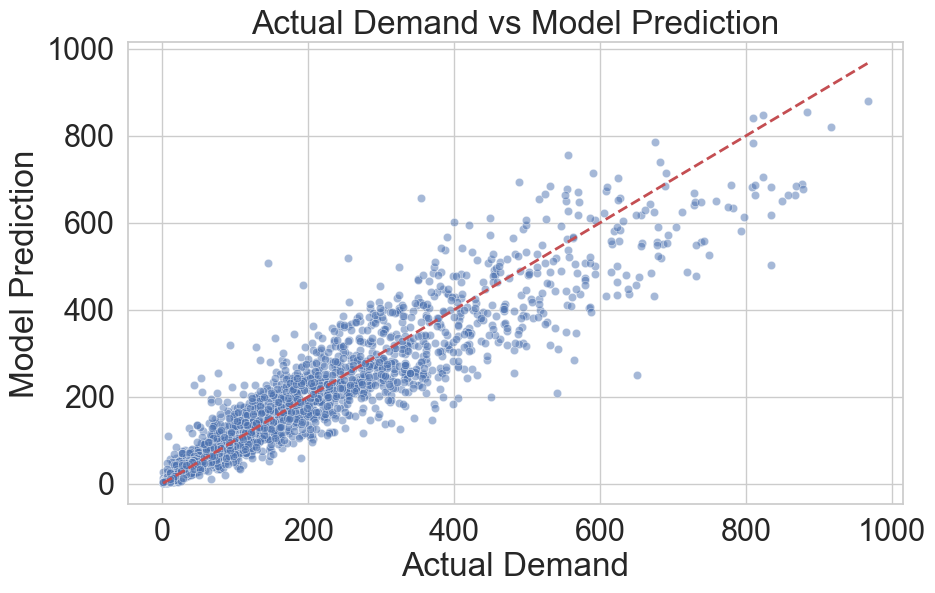

In [68]:
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Demand', y='Model Prediction', data=df_result, alpha=0.5)
plt.plot([df_result['Actual Demand'].min(), df_result['Actual Demand'].max()],
         [df_result['Actual Demand'].min(), df_result['Actual Demand'].max()],
         'r--', lw=2)
plt.xlabel('Actual Demand')
plt.ylabel('Model Prediction')
plt.title('Actual Demand vs Model Prediction')
plt.show()

**Residual plot** the bigger the total bike demand our predictions can be off by about 33% from the actual values. This high MAPE indicates that while our model captures general trends, it still has room for improvement, especially in predicting high-demand scenarios."

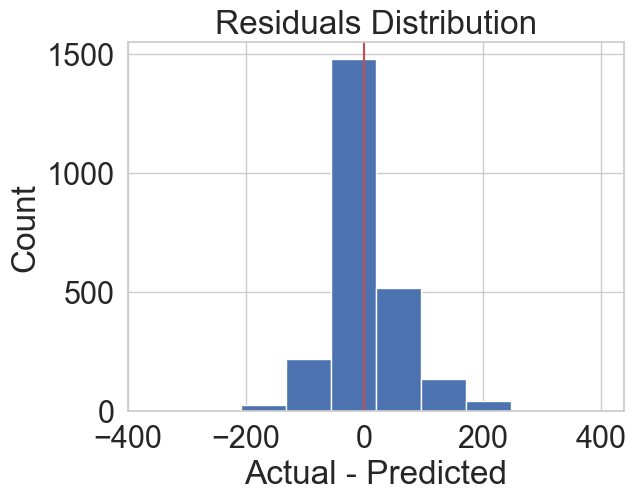

In [69]:
import matplotlib.pyplot as plt
residuals = (df_result['Actual Demand'] - df_result['Model Prediction'])
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()


In [70]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:.2f}'.format(value_counts[False]/len(residuals)))


 Under Estimation: 0.51
 Over  Estimation: 0.49


There are 51% predicted values that under the actual values

There are 49% predicted values that over the actual values

In [71]:
import pickle
final_model = xgb_pipeline
final_model.fit(X_train,y_train)
pickle.dump(final_model, open('Model/xgb_model_final.pkl','wb'))

In [72]:
import shap

In [73]:
final_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['weathersit', 'holiday',
                                                   'season', 'quarter', 'day',
                                                   'rush_hour'])])),
                ('modeling',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   col...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=7,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=250,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=None, ...)))])

In [74]:
explainer = shap.Explainer(
    final_model[1].predict,
    final_model[0].transform(X_test)
)
shap_values = explainer(final_model[0].transform(X_test))

PermutationExplainer explainer: 2432it [05:35,  7.22it/s]                          


In [75]:
# shap js
def shap_plot(idx, model, dataset):
    explainerModel = shap.TreeExplainer(model)
    shap_values_model = explainerModel.shap_values(dataset)
    p = shap.force_plot(explainerModel.expected_value, shap_values_model[idx], dataset.iloc[[idx]])
    return (p)

In [76]:
X_test_preprocessed = pd.DataFrame(final_model[0].transform(X_test))
X_test_preprocessed.columns = list_features
# X_test_preprocessed

In [77]:
shap.initjs()

In [78]:

# Find the index of the highest and lowest values in y_test
max_index = y_test.idxmax()
min_index = y_test.idxmin()

# Retrieve the corresponding rows in X_test and the values in y_test
X_test_max = X_test.loc[max_index]
y_test_max = y_test.loc[max_index]

X_test_min = X_test.loc[min_index]
y_test_min = y_test.loc[min_index]

# Print the results
print("Highest y_test value:")
print(f"Index: {max_index}, y_test: {y_test_max}")
print("Corresponding X_test row:")
print(X_test_max)

print("\nLowest y_test value:")
print(f"Index: {min_index}, y_test: {y_test_min}")
print("Corresponding X_test row:")
print(X_test_min)


Highest y_test value:
Index: 2957, y_test: 967
Corresponding X_test row:
hum            0.39
weathersit    Clear
holiday          No
season         Fall
temp           0.66
hr               17
day               1
quarter           3
rush_hour         1
Name: 2957, dtype: object

Lowest y_test value:
Index: 3689, y_test: 1
Corresponding X_test row:
hum              0.8
weathersit     Clear
holiday           No
season        Winter
temp            0.22
hr                 4
day                0
quarter            1
rush_hour          0
Name: 3689, dtype: object


In [79]:
i = 225

inner_model = final_model['modeling'].regressor_

shap_plot(
    i,
    inner_model,
    X_test_preprocessed
)

In [85]:
# We exponential the log values to original value
shap_value_log = 6.78

prediction_original_scale = np.exp(shap_value_log)
print(f"Prediction in original scale: {prediction_original_scale:.2f}")

Prediction in original scale: 880.07


In [81]:
i = 11

inner_model = final_model['modeling'].regressor_

shap_plot(
    i,
    inner_model,
    X_test_preprocessed
)

In [83]:
shap_value_log = 0.74

prediction_original_scale = np.exp(shap_value_log)
print(f"Prediction in original scale: {prediction_original_scale:.2f}")

Prediction in original scale: 2.10


### **Actionable Insights**

In [84]:
peak_rental_rate = 15  
off_peak_rental_rate = 10  
cost_per_bike_per_day = 2 
peak_demand_factor = 0.20  
off_peak_demand_factor = -0.10 



# Calculate predicted peak and off-peak rentals
predicted_peak_rentals = df_result[df_result['rush_hour'] == 1]['Model Prediction'].sum()
predicted_off_peak_rentals = df_result[df_result['rush_hour'] == 0]['Model Prediction'].sum()

# Assuming available bikes is based on total predicted rentals
available_bikes_peak = predicted_peak_rentals + 50  # example buffer
available_bikes_off_peak = predicted_off_peak_rentals + 50  # example buffer

# Calculate adjusted demands
adjusted_peak_demand = predicted_peak_rentals * (1 + peak_demand_factor)
adjusted_off_peak_demand = predicted_off_peak_rentals * (1 + off_peak_demand_factor)

# Calculate revenue and costs
peak_revenue = adjusted_peak_demand * peak_rental_rate
peak_cost_of_excess_bikes = (available_bikes_peak - adjusted_peak_demand) * cost_per_bike_per_day

off_peak_revenue = adjusted_off_peak_demand * off_peak_rental_rate
off_peak_cost_of_excess_bikes = (available_bikes_off_peak - adjusted_off_peak_demand) * cost_per_bike_per_day

# Calculate net profit
net_profit = peak_revenue - peak_cost_of_excess_bikes + off_peak_revenue - off_peak_cost_of_excess_bikes

# Output results
print(f"Predicted Peak Rentals: {predicted_peak_rentals}")
print(f"Adjusted Peak Demand: {round(adjusted_peak_demand)}")
print(f"Peak Revenue: ${round(peak_revenue)}")
print(f"Peak Cost of Excess Bikes: ${round(peak_cost_of_excess_bikes)}")

print(f"\nPredicted Off-Peak Rentals: {round(predicted_off_peak_rentals)}")
print(f"Adjusted Off-Peak Demand: {round(adjusted_off_peak_demand)}")
print(f"Off-Peak Revenue: ${round(off_peak_revenue)}")
print(f"Off-Peak Cost of Excess Bikes: ${round(off_peak_cost_of_excess_bikes)}")

print(f"\nNet Profit: ${round(net_profit)}")

Predicted Peak Rentals: 40805
Adjusted Peak Demand: 48966
Peak Revenue: $734490
Peak Cost of Excess Bikes: $-16222

Predicted Off-Peak Rentals: 201957
Adjusted Off-Peak Demand: 181761
Off-Peak Revenue: $1817613
Off-Peak Cost of Excess Bikes: $40491

Net Profit: $2527834


In [89]:
total_bike_rentals = 40805 + 201957
revenue_per_ride = 1 + (0.05*30) #assuming average rental times 30 minutes

total_normal_revenue = total_bike_rentals + revenue_per_ride
print(f"Net Profit: ${round(total_normal_revenue)}")

Net Profit: $242764


In [92]:
revenue = net_profit - total_normal_revenue
print(f'Differences Revenue: ${round(revenue)}')

Differences Revenue: $2285069


Example of implementing dynamic pricing monthly capital bike marketing can get up to **$2285069** revenue